In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T083107Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4c3d110db371ab3ca3a94e2a2f2c8996b1ad369f0124023ae571dad409a465cf06b2316e5b356ac2c49491291f74ff746fea80cbe6edaf4edc0f04b6b44758d0da6dba20ce4ed2f0b9151c2780d05a4c35900d8a8e24de615c30fad5ec3c1a2bb1d30c621eb2af4a223ed1b9be26d8557c3590f7eb4daf79afc1f67103e82f07cc2d3ac9ecfee25c45a6de884093db98aa942055790848a3911784b6ff99568315139c4a82eab273fffaf7e448d55d9a521ac26eaefdda241b8a558025f5612adc24eef305c932711524a5958f64681e096b809c9bb01d12d53727109fe30bce89b42b107664c38ebdc3770f043d199dbc1326c5e288a64b73198708dbfdec76'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


<h1 align="center"> Credit Fraud Detector </h1>


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('../input/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

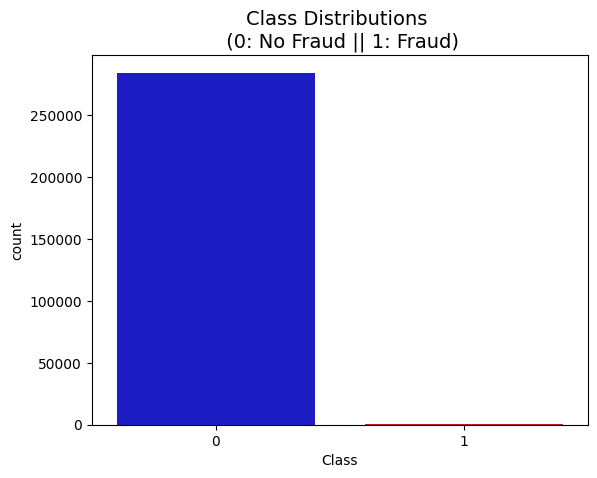

In [13]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x = 'Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

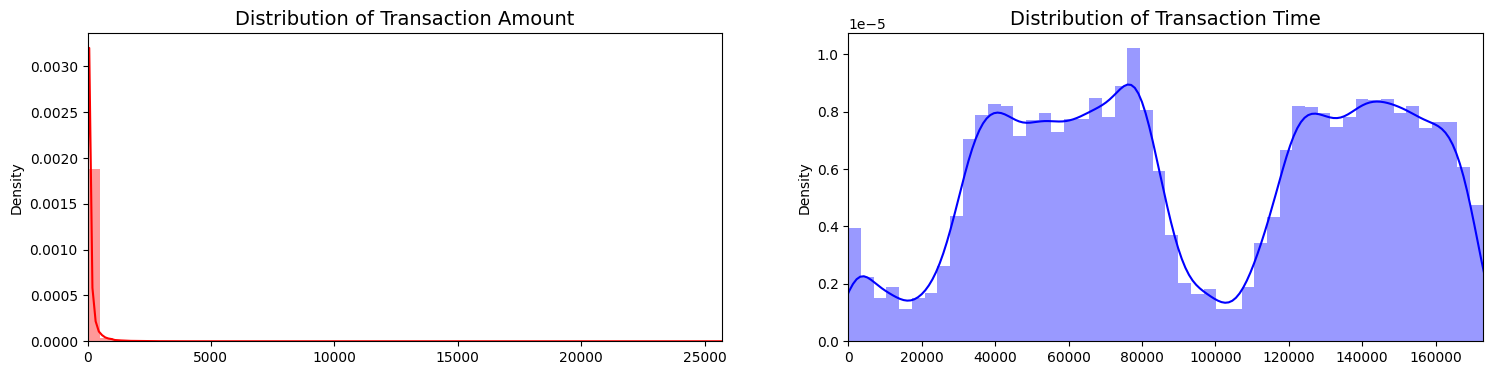

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [15]:
# most of data already scaaled , we scale rest of columns
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler -> less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [16]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [20]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
64271,7.204639,-0.394730,0.137803,-1.486301,-0.050184,2.016529,-1.093290,-0.246554,0.406183,-0.104112,...,0.935189,0.213015,-0.287139,-0.594413,0.343493,0.473325,-0.331593,-0.030072,0.143129,0
149587,-0.293440,0.080264,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,...,-0.230640,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1
270727,6.945294,0.934409,-0.759277,-1.331022,0.151623,-0.726885,-1.806841,0.060065,1.927608,-0.316241,...,0.639170,0.065042,-0.130863,1.303164,-0.013308,-0.922725,0.461668,0.025036,0.262370,0
214662,1.376930,0.647035,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,...,0.589575,0.983481,0.899876,-0.285103,-1.929717,0.319869,0.170636,0.851798,0.372098,1
43773,2.100468,-0.505716,-3.240187,2.978122,-4.162314,3.869124,-3.645256,-0.126271,-4.744730,-0.065331,...,-0.224043,2.601441,0.231910,-0.036490,0.042640,-0.438330,-0.125821,0.421300,0.003146,1


##  Equally Distributing and Correlating:
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


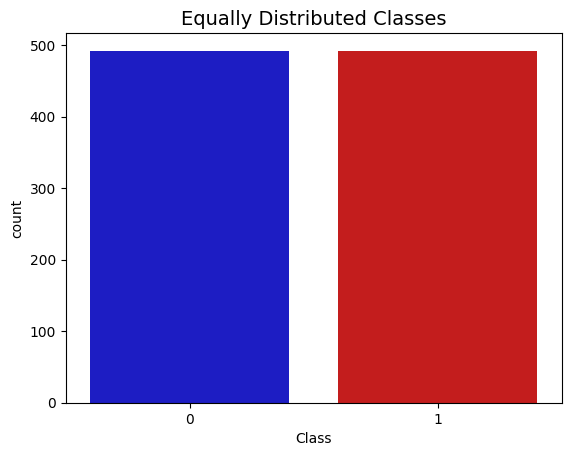

In [22]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> Correlation Matrices </h3>


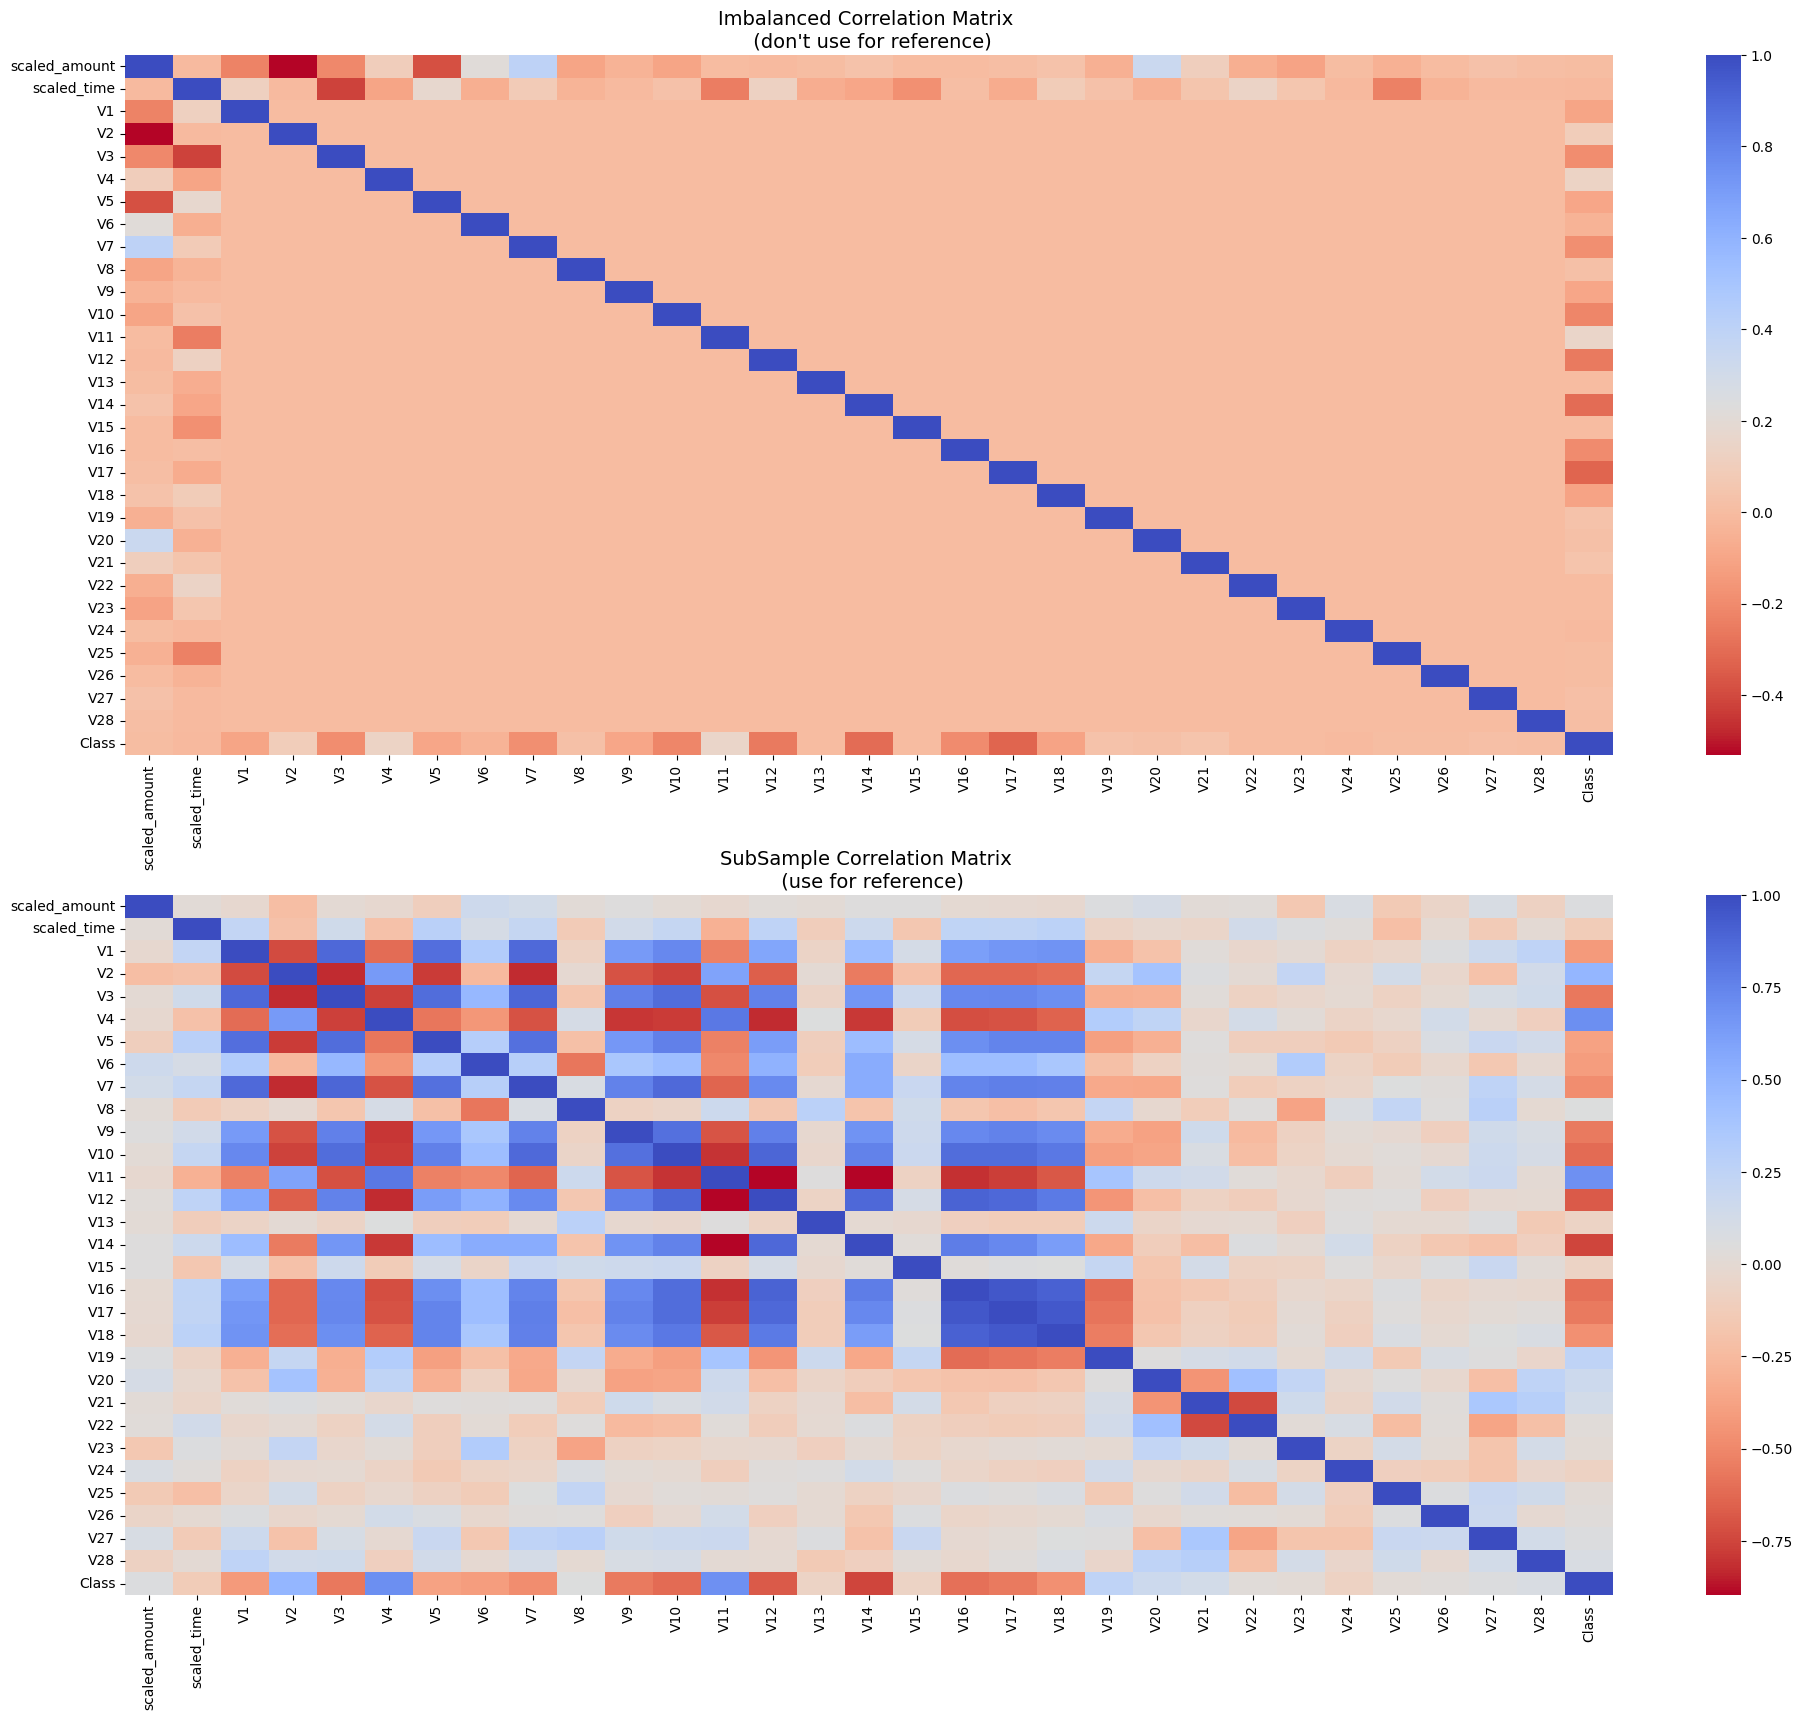

In [23]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

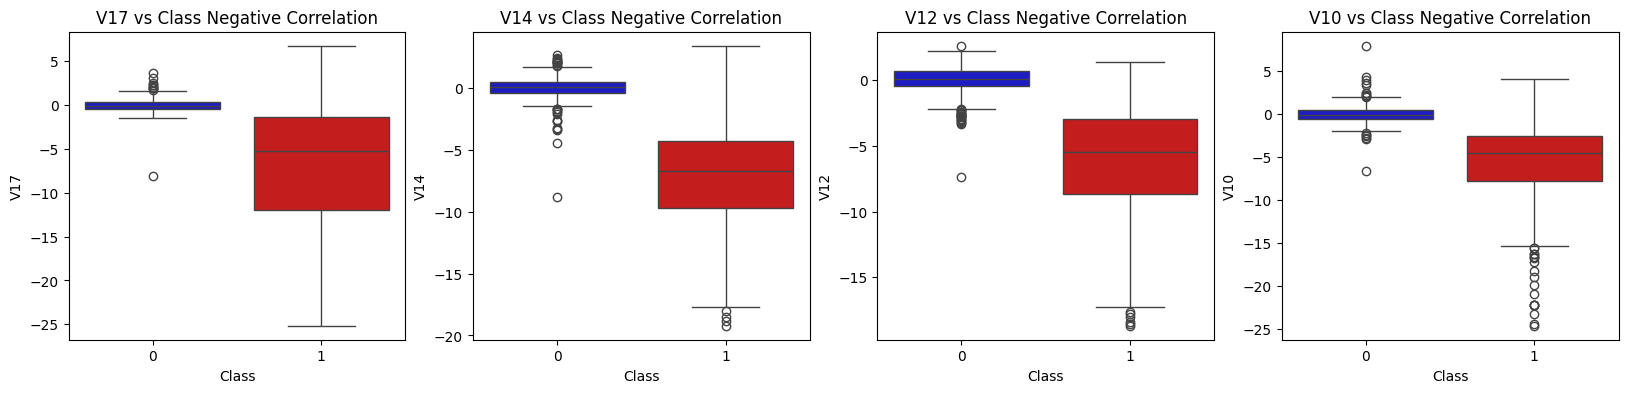

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

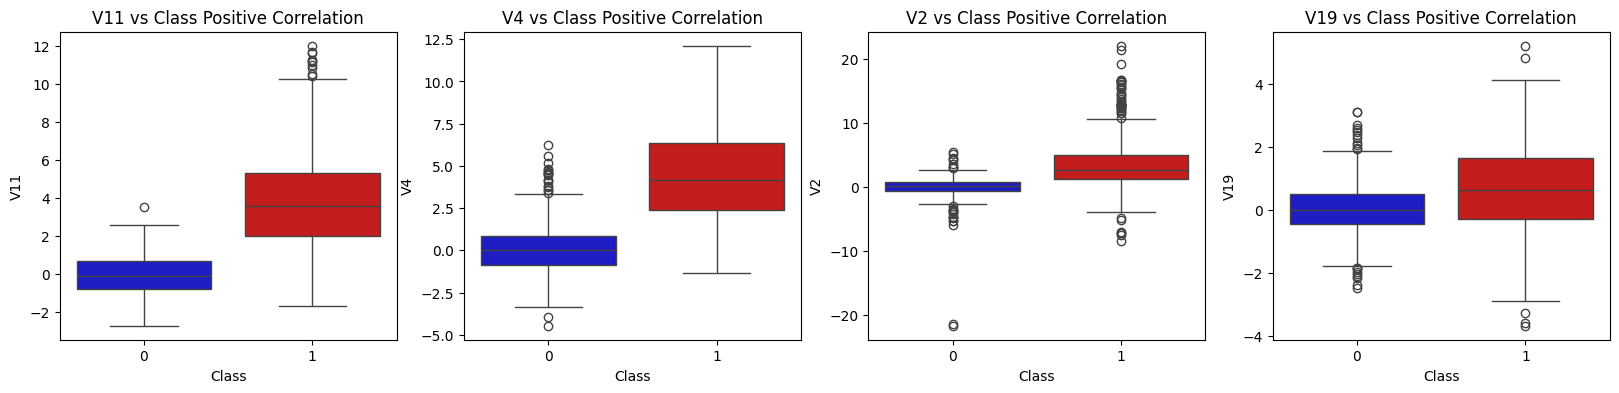

In [25]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection:


Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


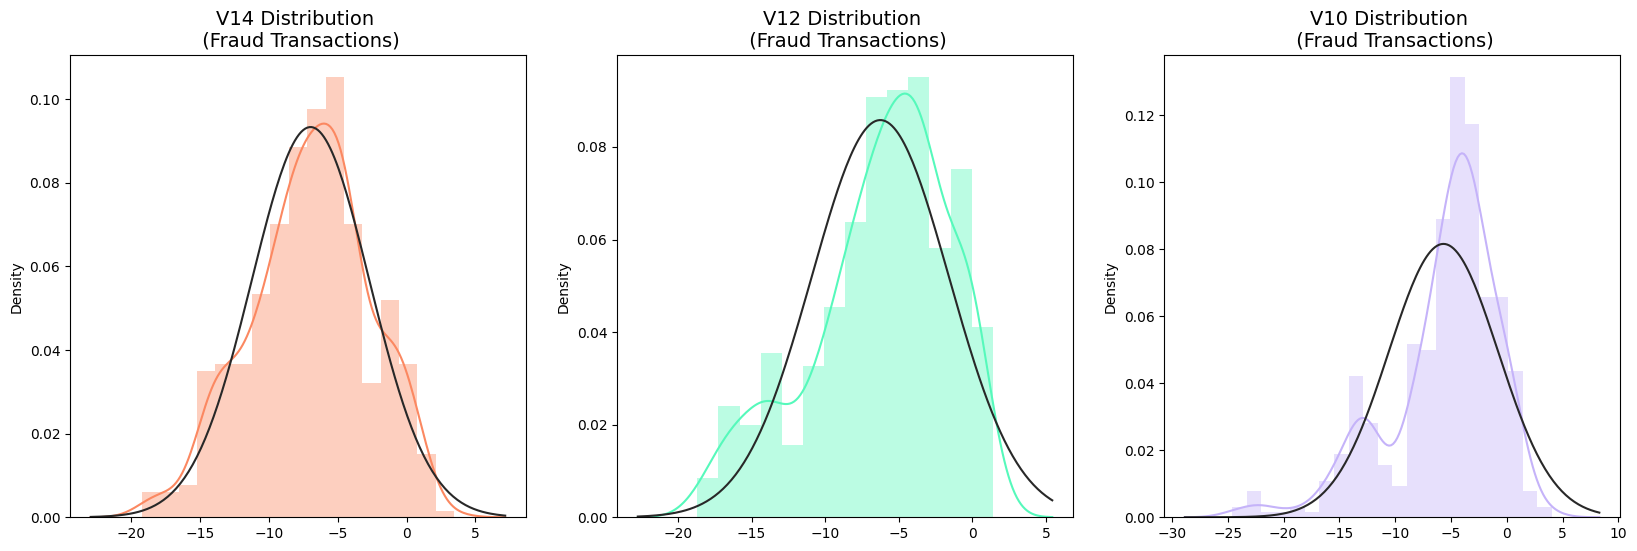

In [26]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [27]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.0499976898594, -18.8220867423816, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.4311310279993, -18.6837146333443, -18.0475965708216]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.3460988468775, -17.141513

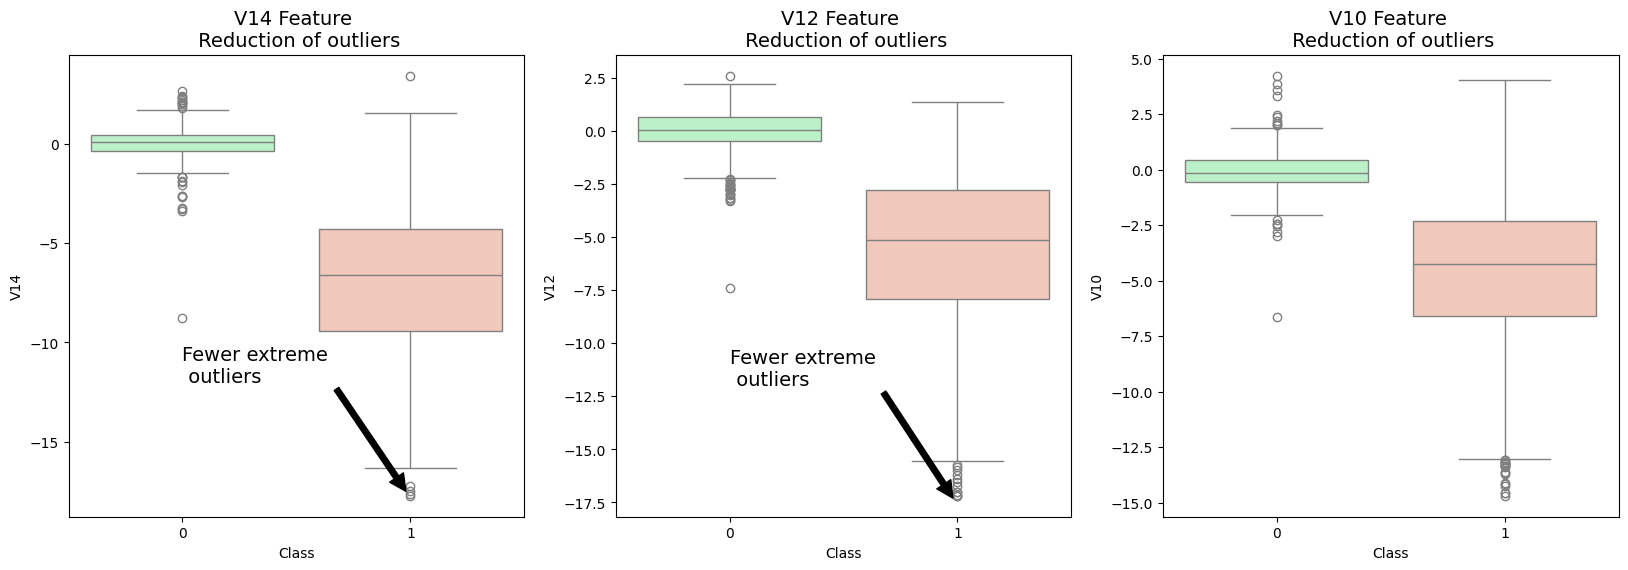

In [28]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

<h2>Dimensionality Reduction and Clustering: </h2>
<h3>t-SNE:  </h3>
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul

In [29]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.5 s
PCA took 0.012 s
Truncated SVD took 0.0099 s


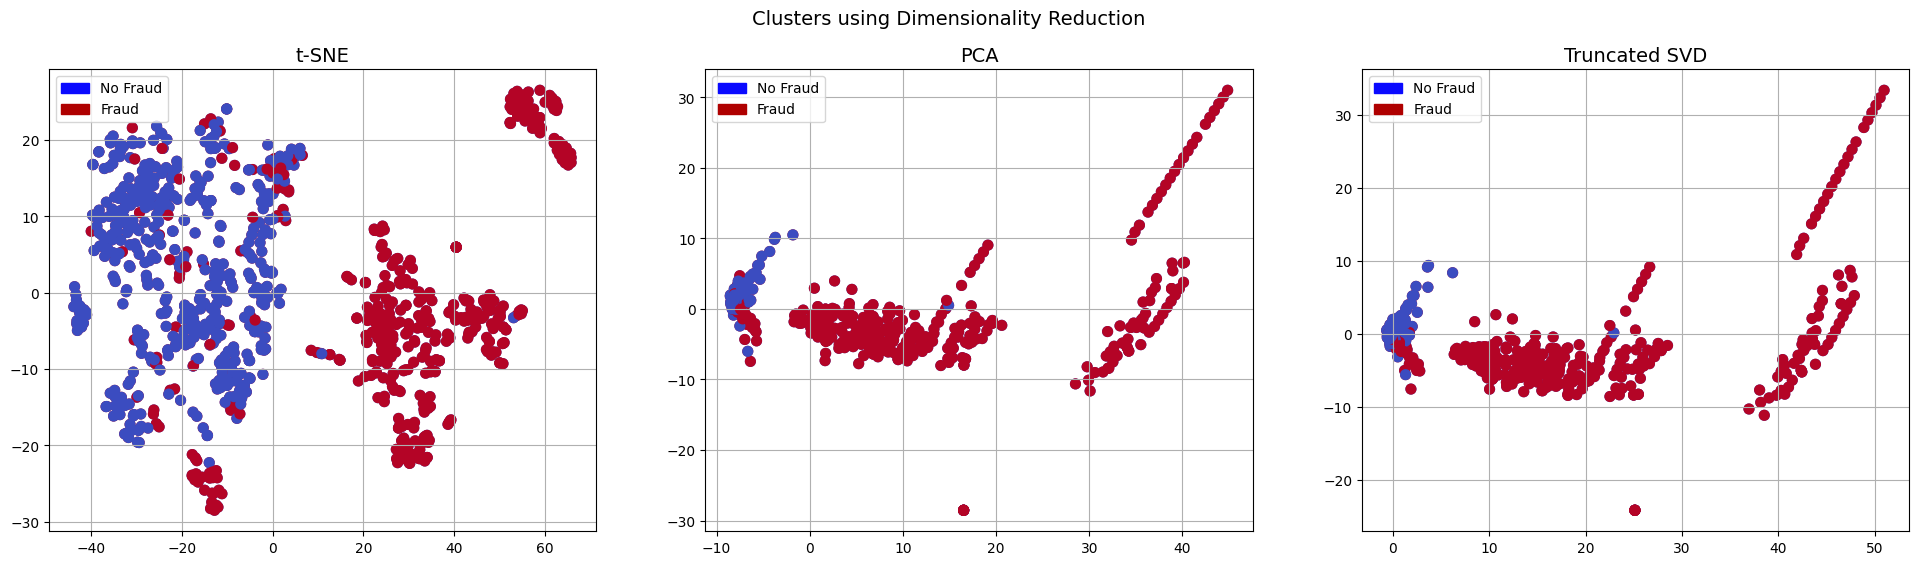

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2> Classifiers (UnderSampling):  </h2>
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before we have to split our data into training and testing sets and separate the features from the labels.

## Summary:
<ul>
<li> <b> Logistic Regression </b> classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression) </li>
<li><b> GridSearchCV </b> is used to determine the paremeters that gives the best predictive score for the classifiers. </li>
<li> Logistic Regression has the best Receiving Operating Characteristic score  (ROC), meaning that LogisticRegression pretty accurately separates <b> fraud </b> and <b> non-fraud </b> transactions.</li>
</ul>

## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

In [31]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [33]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [35]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [36]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


In [37]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [38]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.8%
Knears Neighbors Cross Validation Score 93.4%
Support Vector Classifier Cross Validation Score 93.14%
DecisionTree Classifier Cross Validation Score 92.21%


In [40]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56949  56950  56951 ... 284804 284805 284806] Test: [    0     1     2 ... 61424 61531 62000]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56949  56950  56951 ... 125589 125881 126002]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113896 113897 113898 ... 181985 182043 182763]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170862 170863 170864 ... 231207 232087 232364]
Train: [     0      1      2 ... 231207 232087 232364] Test: [227835 227836 227837 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [41]:
# Plot of LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

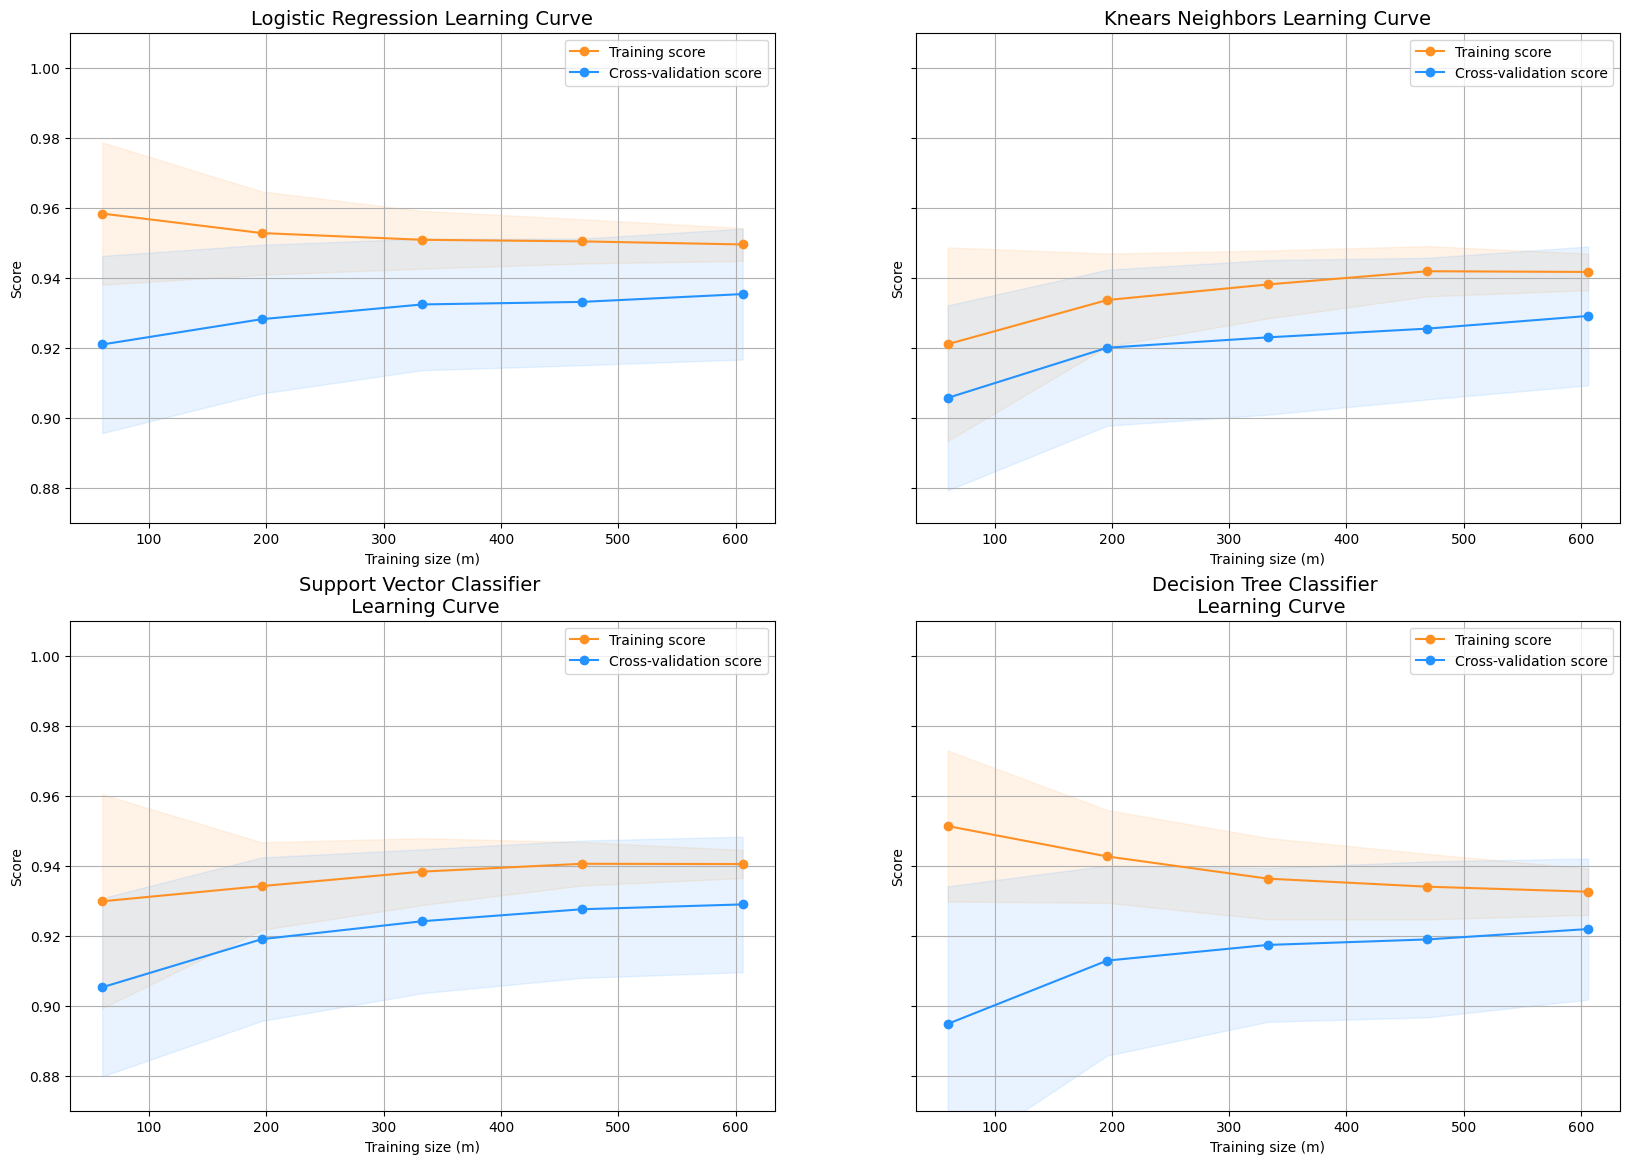

In [42]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [43]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [44]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9750914984837393
KNears Neighbors:  0.9321900379936562
Support Vector Classifier:  0.9774966014848897
Decision Tree Classifier:  0.9204468611663006


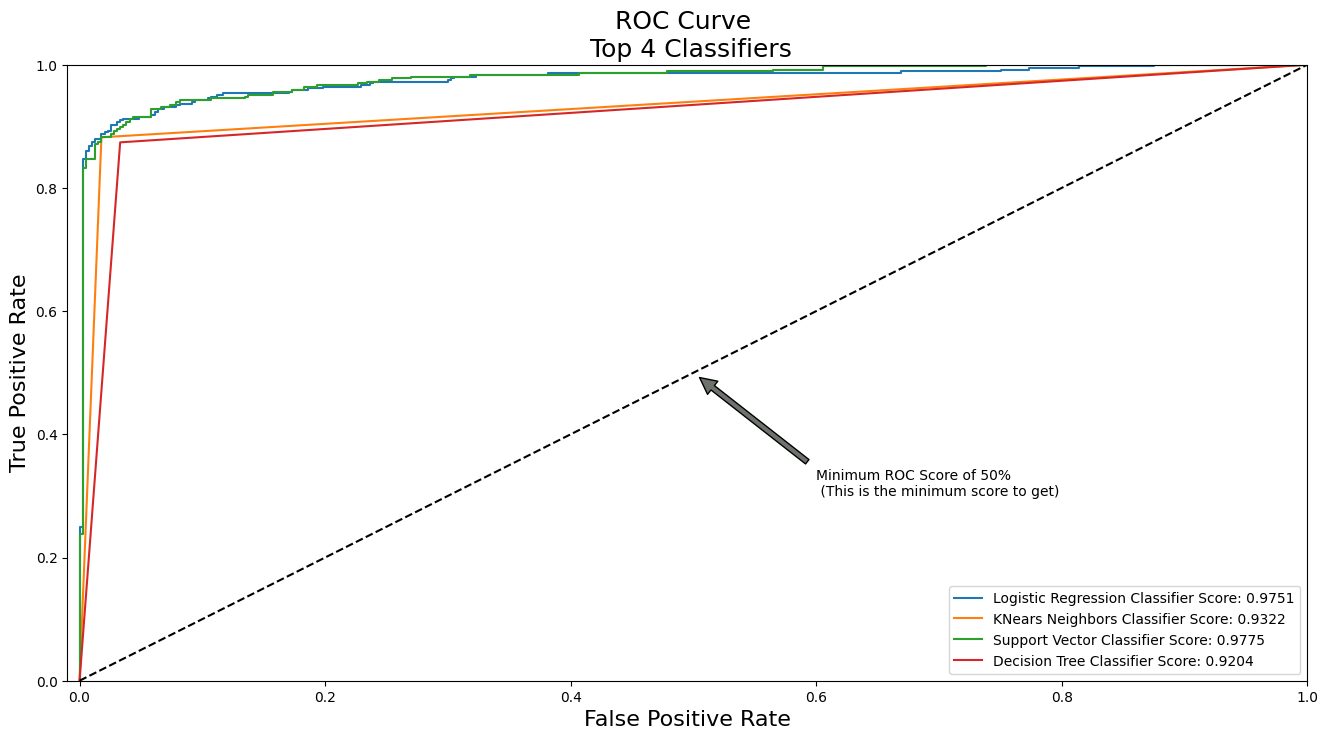

In [45]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

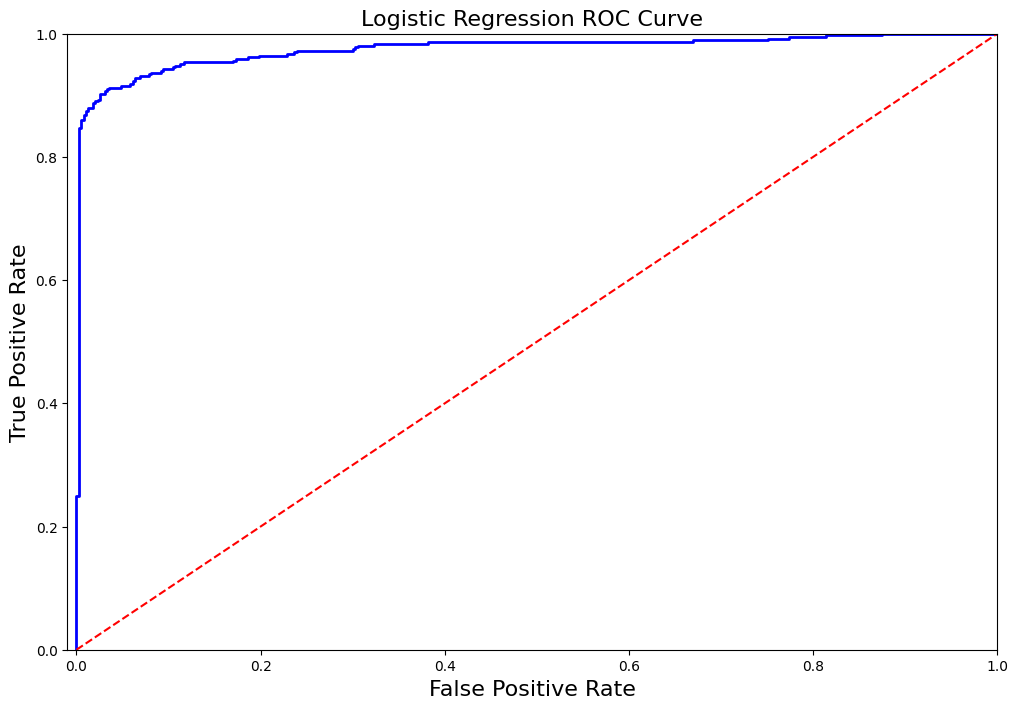

In [46]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [47]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [48]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.92
Precision Score: 0.76
F1 Score: 0.84
Accuracy Score: 0.83
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.74
Precision Score: 0.00
Recall Score: 0.24
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [49]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [50]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.03


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.03')

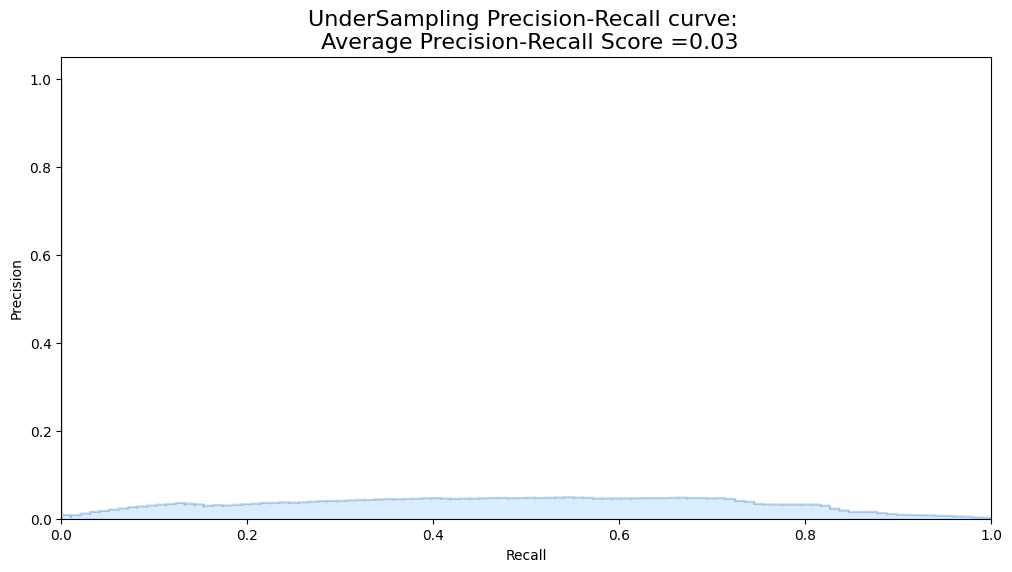

In [51]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

### SMOTE Technique (Over-Sampling):
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9436599651601079
precision: 0.06317937621921896
recall: 0.9162934112301201
f1: 0.11636924083722053
---------------------------------------------------------------------------------------------------------------------------------------


In [53]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



In [54]:
y_score = best_est.decision_function(original_Xtest)

In [55]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.74')

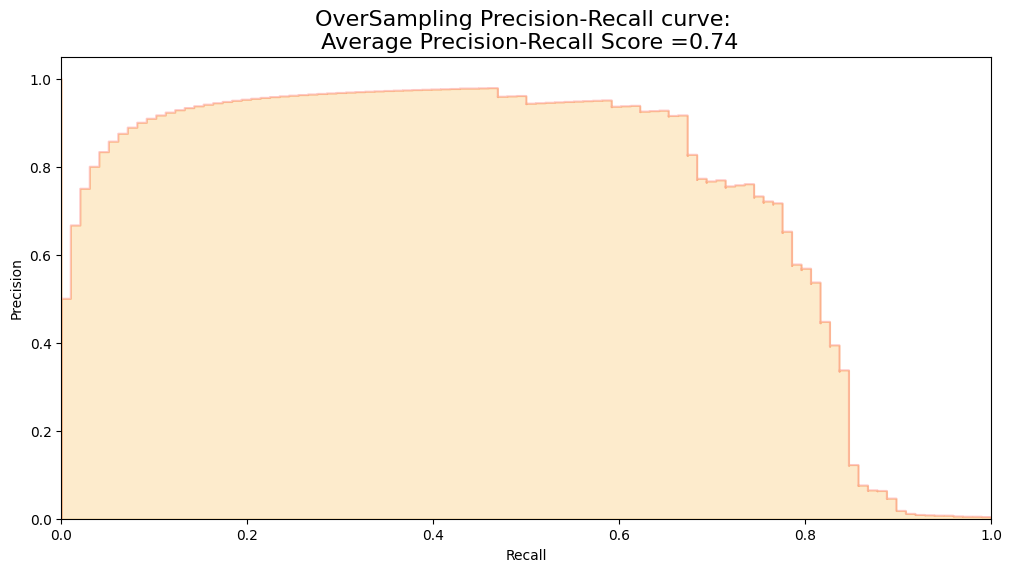

In [56]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [59]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [60]:
# We Improve the score by 2% points approximately
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :7.45025897026062 sec



## Confusion Matrix:
<li> <b>Random UnderSampling:</b> We will evaluate the final performance of the classification models in the random undersampling subset.
<li> <b>Classification Models: </b> The models that performed the best were <b>logistic regression </b> and <b>support vector classifier (SVM)</b>  </li>
</ul>

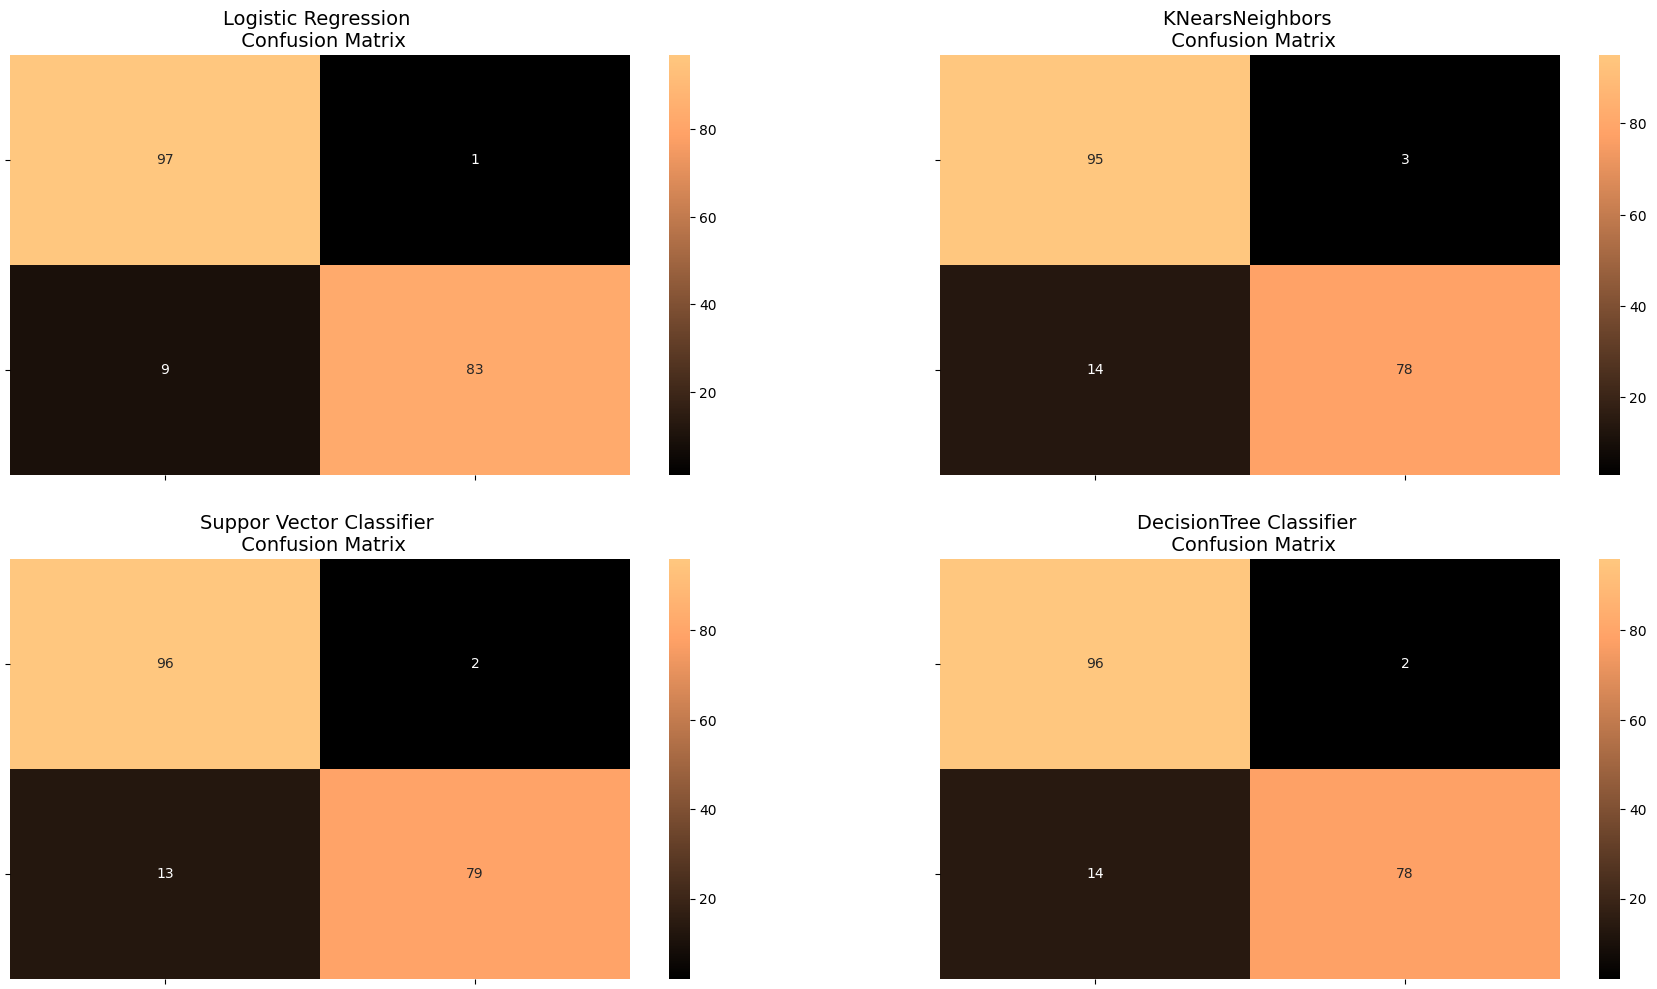

In [61]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [64]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        98
           1       0.99      0.90      0.94        92

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        98
           1       0.96      0.85      0.90        92

    accuracy                           0.91       190
   macro avg       0.92      0.91      0.91       190
weighted avg       0.92      0.91      0.91       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        98
           1       0.98      0.86      0.91        92

    accuracy                           0.92       190
   macro avg       0.93      0.92      0.92       190
weighted

In [65]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

,Technique,Score
0,Random UnderSampling,0.947368
1,Oversampling (SMOTE),0.987886


## Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):
In this section we will implement a simple Neural Network (with one hidden layer) in order to see  which of the two logistic regressions models we implemented in the (undersample or oversample(SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions. <br><br>


### The Confusion Matrix:
<ul>
<li><b>Upper Left Square: </b> The amount of <b>correctly</b> classified by our model of  no fraud transactions. </li>
<li> <b>Upper Right Square:</b> The amount of  <b>incorrectly </b> classified transactions as fraud cases, but the actual label is <b> no fraud </b>. </li>
<li><b>Lower Left Square:</b> The amount of <b> incorrectly </b> classified transactions as no fraud cases, but the actual label is <b>fraud </b>. </li>
<li><b> Lower Right Square:</b> The amount of  <b>correctly</b> classified by our model of fraud transactions. </li>
</ul>

### Summary (Keras || Random UnderSampling):
<ul>
<li><b>Dataset: </b> In this final phase of testing we will fit this model in both the <b>random undersampled subset</b>  and <b> oversampled dataset (SMOTE) </b>in order to predict the final result using the <b>original dataframe testing data.</b> </li>
<li>  <b>Neural Network Structure: </b> It will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud). </li>

 <li>The learning rate will be 0.001 </li>


In [67]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [68]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
undersample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [71]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 3s - loss: 0.5986 - accuracy: 0.6782 - val_loss: 0.4210 - val_accuracy: 0.7895 - 3s/epoch - 131ms/step
Epoch 2/20
25/25 - 0s - loss: 0.3589 - accuracy: 0.8482 - val_loss: 0.3263 - val_accuracy: 0.8684 - 245ms/epoch - 10ms/step
Epoch 3/20
25/25 - 0s - loss: 0.2755 - accuracy: 0.9092 - val_loss: 0.2751 - val_accuracy: 0.9211 - 260ms/epoch - 10ms/step
Epoch 4/20
25/25 - 0s - loss: 0.2351 - accuracy: 0.9257 - val_loss: 0.2538 - val_accuracy: 0.9211 - 263ms/epoch - 11ms/step
Epoch 5/20
25/25 - 0s - loss: 0.2052 - accuracy: 0.9340 - val_loss: 0.2288 - val_accuracy: 0.9408 - 215ms/epoch - 9ms/step
Epoch 6/20
25/25 - 0s - loss: 0.1847 - accuracy: 0.9373 - val_loss: 0.2140 - val_accuracy: 0.9408 - 271ms/epoch - 11ms/step
Epoch 7/20
25/25 - 0s - loss: 0.1664 - accuracy: 0.9455 - val_loss: 0.2049 - val_accuracy: 0.9408 - 255ms/epoch - 10ms/step
Epoch 8/20
25/25 - 0s - loss: 0.1538 - accuracy: 0.9505 - val_loss: 0.1992 - val_accuracy: 0.9408 - 341ms/epoch - 14ms/step
Epoch 9/20


In [73]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [75]:
predictions_prob = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = np.argmax(predictions_prob, axis=1)

In [76]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55008  1855]
 [    8    90]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


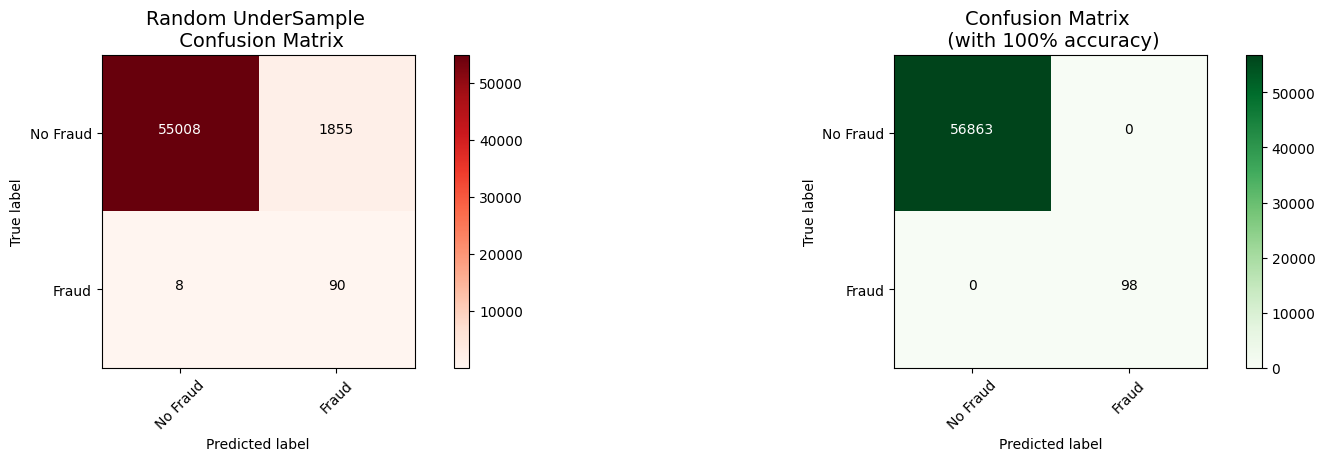

In [77]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [80]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [81]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 9s - loss: 0.0673 - accuracy: 0.9760 - val_loss: 0.0188 - val_accuracy: 0.9971 - 9s/epoch - 7ms/step
Epoch 2/20
1214/1214 - 6s - loss: 0.0123 - accuracy: 0.9972 - val_loss: 0.0062 - val_accuracy: 0.9999 - 6s/epoch - 5ms/step
Epoch 3/20
1214/1214 - 5s - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.0222 - val_accuracy: 0.9953 - 5s/epoch - 4ms/step
Epoch 4/20
1214/1214 - 4s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 1.0000 - 4s/epoch - 3ms/step
Epoch 5/20
1214/1214 - 6s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0043 - val_accuracy: 0.9998 - 6s/epoch - 5ms/step
Epoch 6/20
1214/1214 - 5s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 1.0000 - 5s/epoch - 4ms/step
Epoch 7/20
1214/1214 - 3s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 8/20
1214/1214 - 3s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0018 - val_accuracy: 1.0000 - 3s/epoch - 3ms/step
Epoch 9/

In [83]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [86]:
predictions_prob_oversample = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(predictions_prob_oversample, axis=1)

Confusion matrix, without normalization
[[56837    26]
 [   27    71]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


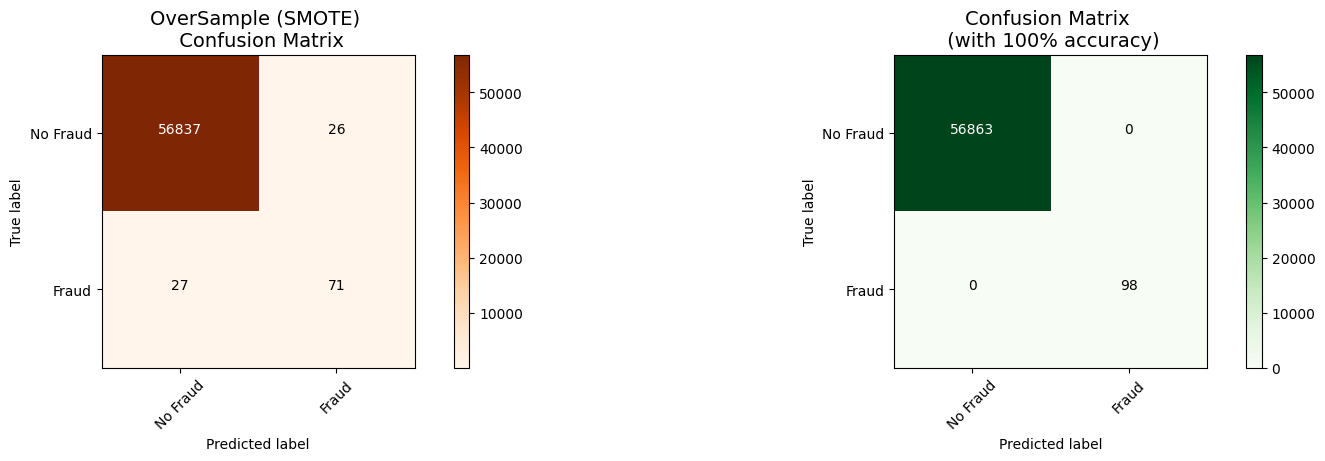

In [87]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)